In [ ]:
from google.colab import userdata

github_token = userdata.get("GITHUB_TOKEN")

# Install the private repository using the token
! pip install nnsight -q
!pip install --upgrade git+https://{github_token}@github.com/withmartian/TinySQL.git

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 36.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 5.8 MB/s eta 0:00:00
  Cloning https://****@github.com/withmartian/TinySQL.git to /tmp/pip-req-build-9hg1gxvf
  Running command git clone --filter=blob:none --quiet 'https://****@github.com/withmartian/TinySQL.git' /tmp/pip-req-build-9hg1gxvf
  Resolved https://****@github.com/withmartian/TinySQL.git to commit f0a39572e84baa3cc434f83d245c68e1ef3da0b8
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for TinySQL: filename=TinySQL-1.0-py3-none-any.whl size=51800 sha256=a281825827b1bfd3d2d449b76d4e3cac0302e2bbef378926b2da15791ed60896
  Stored in directory: /tmp/pip-ephem-wheel-cache-yj9hfvh5/wheels/a9/72/1c/ba39c57a9acd2e1efd9554f1a2ed8d8987923fbad44ab80971
Successfully built TinyS

# BM1 CS1

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from TinySQL.load_data.load_model import load_tinysql_model

device = torch.device('cuda')

tokenizer_sql = AutoTokenizer.from_pretrained('withmartian/sql_interp_bm1_cs1_experiment_1.8')
tokenizer_sql.pad_token = tokenizer_sql.eos_token

model_sql = AutoModelForCausalLM.from_pretrained(
    'withmartian/sql_interp_bm1_cs1_experiment_1.8',
    pad_token_id=tokenizer_sql.eos_token_id
)
model_sql.config.pad_token_id = tokenizer_sql.pad_token_id
model_sql.to(device)

## BM1 CS1: **DefCreateTable**, **EngFieldStart**, **EngFieldSeparator**, **DefFieldSeparator** features

In [ ]:
def is_in_tiny_stories_vocab(word, tokenizer):
    word = word.lower()

    tokens = tokenizer.encode(word, add_special_tokens=False)

    return len(tokens) == 1

words_ts = [
           "select", "show", "pick", "find",
           "pull", "grab", "take", "move", "walk",
           "run", "jump", "stop", "sing", "fly"
       ]

for word in words_ts:
  print(is_in_tiny_stories_vocab(word, tokenizer_sql))

In [ ]:
import matplotlib.pyplot as plt
import torch
from TinySQL.corrupt_data.clean_corrupt_data import CorruptFeatureTestGenerator

class SimpleSimilarityTester(CorruptFeatureTestGenerator):
    def __init__(self, generate_fn, model, tokenizer, corruption='EngFieldStart', model_type='default', *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.generate = generate_fn
        self.test_words = [
            "select", "show", "pick", "find",
            "pull", "grab", "take", "move", "walk",
            "run", "jump", "stop", "sing", "fly", 'create'
        ]
        self.test_separators = [
            ",", ";", "&", "|", ":",
            "#", "@", "$", "^", "~",
            "+", "->", "=>", "--", "//", 'and'
        ]
        self.corruption = corruption
        self.model = model
        self.tokenizer = tokenizer
        self.model_type = model_type

    def get_embeddings(self, input_ids):
        """Helper method to get embeddings based on model type"""
        with torch.no_grad():
            if self.model_type == 'qwen':
                return self.model.model(input_ids).last_hidden_state.mean(dim=1)
            else:
                return self.model.transformer(input_ids).last_hidden_state.mean(dim=1)

    def compute_similarity(self, str1: str, str2: str) -> float:
        inputs1 = self.tokenizer(str1, return_tensors='pt', padding=True).to(self.model.device)
        inputs2 = self.tokenizer(str2, return_tensors='pt', padding=True).to(self.model.device)

        embeddings1 = self.get_embeddings(inputs1.input_ids)
        embeddings2 = self.get_embeddings(inputs2.input_ids)

        similarity = torch.cosine_similarity(embeddings1, embeddings2)
        return similarity.item()

    def test_breakdown(self):
        base_item = self._make_base_item()
        base_prompt = base_item.get_alpaca_prompt().replace("show me", "select")
        base_output = self.generate(base_prompt, self.model, self.tokenizer).split()
        results = []

        if self.corruption == 'EngFieldStart':
            print('corrupting EngFieldStart')
            word_similarities = [(word, self.compute_similarity("select", word))
                               for word in self.test_words]
            word_similarities.sort(key=lambda x: x[1])
            for word, similarity in word_similarities:
                corrupted_prompt = base_prompt.replace("select", word)
                corrupt_output = self.generate(corrupted_prompt, self.model, self.tokenizer).split()

                output_similarities = []
                for w1, w2 in zip(base_output, corrupt_output):
                    if w1 == w2:
                        output_similarities.append(1.0)
                    else:
                        output_similarities.append(self.compute_similarity(w1, w2))

                avg_output_similarity = sum(output_similarities) / len(output_similarities) if output_similarities else 0
                results.append((word, avg_output_similarity))

        if self.corruption == 'DefCreateTable':
            print('corrupting DefCreateTable')
            word_similarities = [(word, self.compute_similarity("create", word))
                               for word in self.test_words]
            word_similarities.sort(key=lambda x: x[1])

            for word, similarity in word_similarities:
                corrupted_prompt = base_prompt.replace("CREATE", word.upper())
                corrupt_output = self.generate(corrupted_prompt, self.model, self.tokenizer).split()

                output_similarities = []
                for w1, w2 in zip(base_output, corrupt_output):
                    if w1 == w2:
                        output_similarities.append(1.0)
                    else:
                        output_similarities.append(self.compute_similarity(w1, w2))
                avg_output_similarity = sum(output_similarities) / len(output_similarities) if output_similarities else 0
                results.append((word, avg_output_similarity))

        if self.corruption == 'EngFieldSeparator':
            print('corrupting EngFieldSeparator')
            word_similarities = [(word, self.compute_similarity("and", word))
                               for word in self.test_separators]
            word_similarities.sort(key=lambda x: x[1])
            for word, similarity in word_similarities:
                corrupted_prompt = base_prompt.replace("and", word)
                corrupt_output = self.generate(corrupted_prompt, self.model, self.tokenizer).split()
                output_similarities = []
                for w1, w2 in zip(base_output, corrupt_output):
                    if w1 == w2:
                        output_similarities.append(1.0)
                    else:
                        output_similarities.append(self.compute_similarity(w1, w2))

                avg_output_similarity = sum(output_similarities) / len(output_similarities) if output_similarities else 0
                results.append((word, avg_output_similarity))

        if self.corruption == 'DefFieldSeparator':
            print('corrupting DefFieldSeparator')
            word_similarities = [(word, self.compute_similarity(",", word))
                               for word in self.test_separators]
            word_similarities.sort(key=lambda x: x[1])
            for word, similarity in word_similarities:
                corrupted_prompt = base_prompt.replace(",", word)
                corrupt_output = self.generate(corrupted_prompt, self.model, self.tokenizer).split()

                output_similarities = []
                for w1, w2 in zip(base_output, corrupt_output):
                    if w1 == w2:
                        output_similarities.append(1.0)
                    else:
                        output_similarities.append(self.compute_similarity(w1, w2))

                avg_output_similarity = sum(output_similarities) / len(output_similarities) if output_similarities else 0
                results.append((word, avg_output_similarity))

        self.plot_results(results, word_similarities)
        return results

    def plot_results(self, results, word_similarities):
        output_color = "#8ECAE6"  # Soft blue
        input_color = "#A06CD5"   # Medium purple

        sorted_results = [(w, out_sim) for (w, _), (_, out_sim)
                         in sorted(zip(word_similarities, results),
                                 key=lambda x: x[0][1], reverse=True)]

        words, output_sims = zip(*sorted_results)
        input_sims = [sim for _, sim in sorted(word_similarities,
                                             key=lambda x: x[1],
                                             reverse=True)]

        plt.figure(figsize=(12, 6))
        plt.plot(range(len(words)), output_sims, color=output_color, ls='-', marker='o', label='Output Similarity')
        plt.plot(range(len(words)), input_sims, color=input_color, ls='--', marker='s', label='Input Similarity')
        plt.xticks(range(len(words)), words, rotation=45)

        for i, (out_sim, in_sim) in enumerate(zip(output_sims, input_sims)):
            plt.text(i, out_sim, f'{out_sim:.3f}', ha='center', va='bottom', color=output_color)
            plt.text(i, in_sim, f'{in_sim:.3f}', ha='center', va='bottom', color=input_color)

        plt.xlabel(f'{self.corruption} (Ordered by Input Similarity)')
        plt.ylabel('Similarity Score')
        plt.title(f'Model Sensitivity to {self.corruption} Substitution')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(f'{self.corruption}_breakdown.png', dpi=300)
        plt.show()

def generate_wrapper(prompt, model, tokenizer):
    inputs = tokenizer(prompt, return_tensors='pt', padding=True).to(model.device)
    outputs = model.generate(
        inputs.input_ids,
        attention_mask=inputs.attention_mask,
        max_new_tokens=100,
        pad_token_id=tokenizer.pad_token_id,
        do_sample=False
    )
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

corrupting DefCreateTable


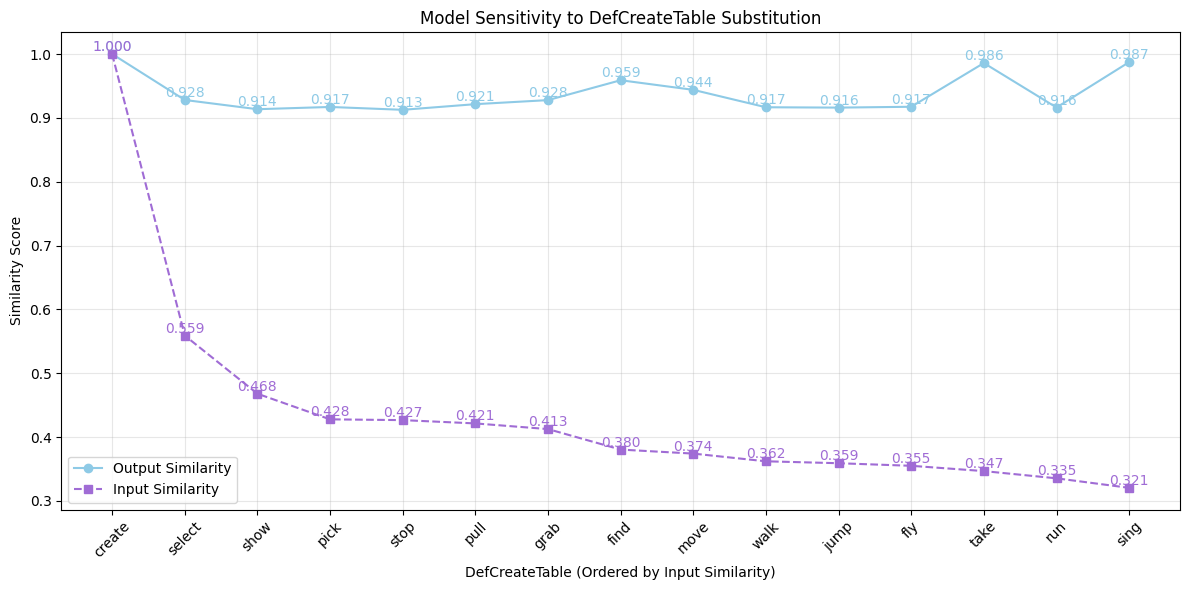

In [ ]:
tester = SimpleSimilarityTester(generate_wrapper, "DefCreateTable", model = model_sql, tokenizer = tokenizer_sql)
results = tester.test_breakdown()

corrupting EngFieldStart


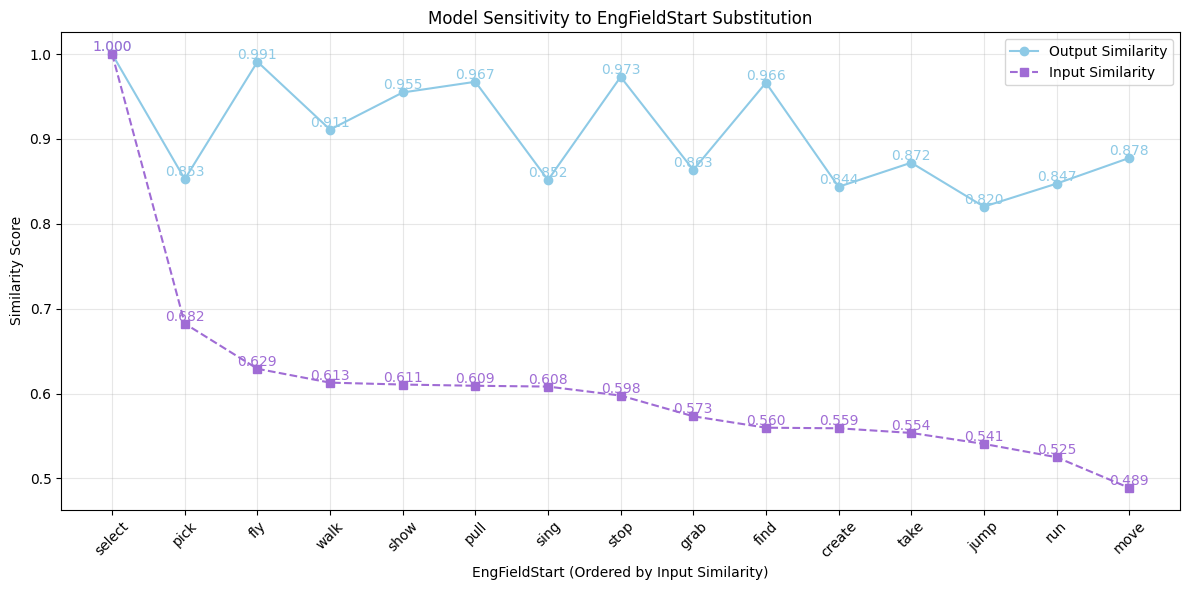

In [ ]:
tester = SimpleSimilarityTester(generate_wrapper, "EngFieldStart")
results = tester.test_breakdown()

corrupting EngFieldSeparator


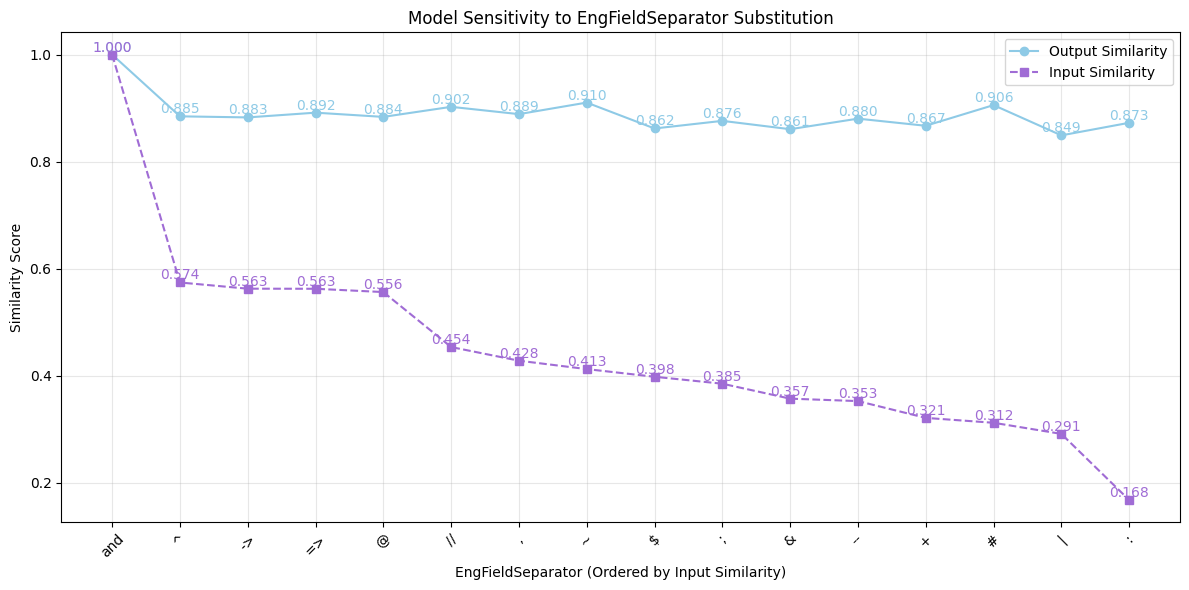

In [ ]:
tester = SimpleSimilarityTester(generate_wrapper, "EngFieldSeparator")
results = tester.test_breakdown()

corrupting DefFieldSeparator


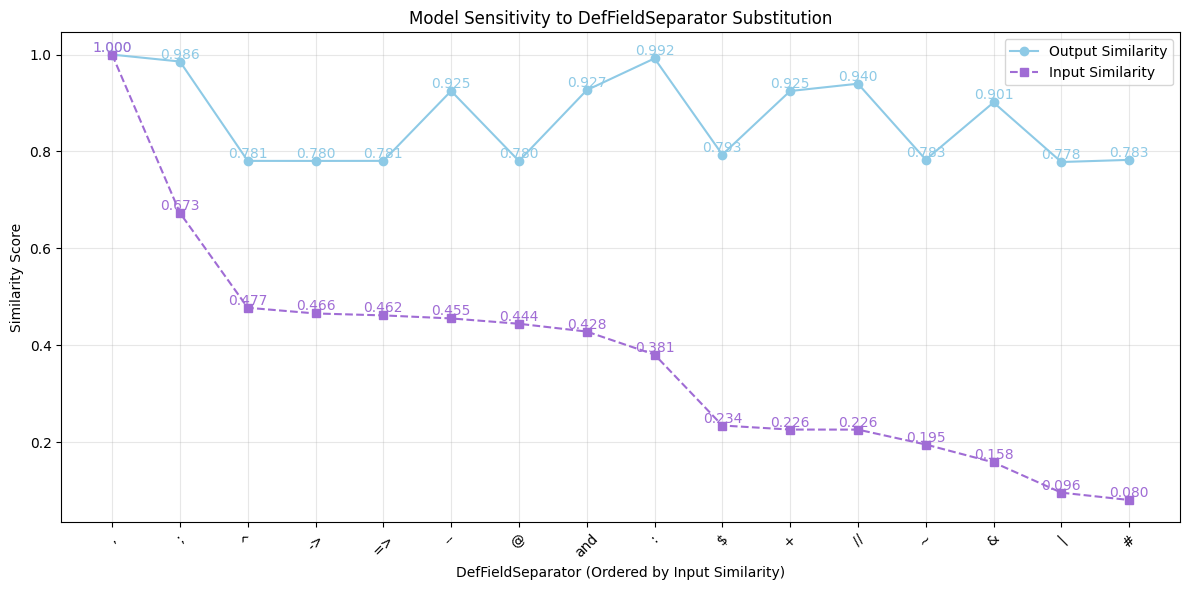

In [ ]:
tester = SimpleSimilarityTester(generate_wrapper, "DefFieldSeparator")
results = tester.test_breakdown()

## BM1 CS1 Duplicate Tokens

### Some functions

In [ ]:
def is_in_tiny_stories_vocab(word, tokenizer):
    word = word.lower()

    tokens = tokenizer.encode(word, add_special_tokens=False)

    return len(tokens) == 1

In [ ]:
from TinySQL.corrupt_data.clean_corrupt_data import CorruptFeatureTestGenerator as cpt
import random
random.seed(42)
def generate_output(prompt, model, tokenizer):
    inputs = tokenizer(
        prompt,
        return_tensors='pt',
        padding=True,
        truncation=True,
        return_attention_mask=True
    ).to(model.device)

    outputs = model.generate(
        input_ids=inputs.input_ids,
        attention_mask=inputs.attention_mask,
        pad_token_id=tokenizer.eos_token_id
    )
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

In [ ]:
from tqdm import tqdm

def compute_average_similarities(n_iterations, model, tokenizer,use_order_by=False):
    total_similarities = {
        'SwapEng2': 0.0,
        'SwapEng1': 0.0,
        'SwapCreate1': 0.0,
        'SwapCreate2': 0.0
    }

    successful_iterations = {
        'SwapEng2': 0,
        'SwapEng1': 0,
        'SwapCreate1': 0,
        'SwapCreate2': 0
    }

    swap_functions = {
        'SwapEng2': swap_field_table_eng_2field,
        'SwapEng1': swap_field_table_eng_1field,
        'SwapCreate1': swap_field_table_create_1field,
        'SwapCreate2': swap_field_table_create_2field
    }

    for i in tqdm(range(n_iterations)):
        try:
            base_item = CorruptFeatureTestGenerator(use_order_by=use_order_by)._make_base_item()
            base_prompt = base_item.get_alpaca_prompt()
            base_output = generate_output(base_prompt, model, tokenizer)
            base_part = base_output.split('### Response:')[1].strip()
            if base_part is not None:
                for name, func in swap_functions.items():
                    try:
                        result = func(base_prompt)
                        swapped_output = generate_output(result, model, tokenizer)
                        swapped_part = swapped_output.split('### Response:')[1].strip()

                        if swapped_part is not None:
                            total_similarities[name] += similarity(base_part, swapped_part, model, tokenizer)
                            successful_iterations[name] += 1
                    except Exception as e:
                        print(f"Error in swap function {name}: {e}")
                        continue
        except Exception as e:
            print(f"Error in iteration {i}: {e}")
            continue

    average_similarities = {}
    for name in swap_functions.keys():
        average_similarities[name] = total_similarities[name] / successful_iterations[name] if successful_iterations[name] > 0 else 0.0

    return average_similarities

In [ ]:
import re

def swap_field_table_eng_1field(sql_text):
    instruction_text = re.search(r'### Instruction:(.*?)### Context:', sql_text, re.DOTALL)
    instruction = instruction_text.group(1).strip()

    # Simplified table pattern
    table_pattern = r'from the (\w+)'
    table_match = re.search(table_pattern, instruction.lower())
    table_name = table_match.group(1) if table_match else None

    # Simplified field pattern to match "show me the X" format
    fields_pattern = r'show me the (\w+)'
    field_match = re.search(fields_pattern, instruction.lower())
    first_field = field_match.group(1) if field_match else None

    new_text = sql_text.replace(first_field, "TEMP", 1)
    new_text = new_text.replace(table_name, first_field, 1)
    new_text = new_text.replace("TEMP", table_name, 1)

    return new_text

def swap_field_table_eng_2field(sql_text):
    instruction_text = re.search(r'### Instruction:(.*?)### Context:', sql_text, re.DOTALL)
    instruction = instruction_text.group(1).strip()

    # Simplified table pattern
    table_pattern = r'from the (\w+)'
    table_match = re.search(table_pattern, instruction.lower())
    table_name = table_match.group(1) if table_match else None

    # Modified to catch the second field after "and"
    fields_pattern = r'and (\w+)'
    field_match = re.search(fields_pattern, instruction.lower())
    second_field = field_match.group(1) if field_match else None

    new_text = sql_text.replace(second_field, "TEMP", 1)
    new_text = new_text.replace(table_name, second_field, 1)
    new_text = new_text.replace("TEMP", table_name, 1)

    return new_text

def swap_field_table_create_1field(sql_text):
    sections = re.search(r'### Context:(.*?)### Response:', sql_text, re.DOTALL)
    if not sections:
        return sql_text

    context_section = sections.group(1)

    # Simplified CREATE TABLE pattern
    table_pattern = r'CREATE TABLE (\w+)'
    table_match = re.search(table_pattern, context_section)
    table_name = table_match.group(1) if table_match else None

    # Simplified first field pattern
    field_pattern = r'\(\s*(\w+)'
    field_match = re.search(field_pattern, context_section)
    first_field = field_match.group(1) if field_match else None

    if table_name and first_field:
        temp_context = context_section.replace(first_field, "TEMP", 1)
        temp_context = temp_context.replace(table_name, first_field, 1)
        new_context = temp_context.replace("TEMP", table_name, 1)

        before_context = sql_text.split("### Context:")[0]
        after_context = sql_text.split("### Response:")[1]

        return before_context + "### Context:" + new_context + "### Response:" + after_context

    return sql_text

def swap_field_table_create_2field(sql_text):
    sections = re.search(r'### Context:(.*?)### Response:', sql_text, re.DOTALL)
    if not sections:
        return sql_text

    context_section = sections.group(1)

    # Simplified CREATE TABLE pattern
    table_pattern = r'CREATE TABLE (\w+)'
    table_match = re.search(table_pattern, context_section)
    table_name = table_match.group(1) if table_match else None

    # Simplified second field pattern
    field_pattern = r',\s*(\w+)'
    field_match = re.search(field_pattern, context_section)
    second_field = field_match.group(1) if field_match else None

    if table_name and second_field:
        temp_context = context_section.replace(second_field, "TEMP", 1)
        temp_context = temp_context.replace(table_name, second_field, 1)
        new_context = temp_context.replace("TEMP", table_name, 1)

        before_context = sql_text.split("### Context:")[0]
        after_context = sql_text.split("### Response:")[1]

        return before_context + "### Context:" + new_context + "### Response:" + after_context

    return sql_text

def similarity(base_output, corrupt_output, model, tokenizer):

  def _compute_similarity(str1, str2):
    inputs1 = tokenizer(str1, return_tensors='pt', padding=True).to(model.device)
    inputs2 = tokenizer(str2, return_tensors='pt', padding=True).to(model.device)

    with torch.no_grad():
        embeddings1 = model.transformer(inputs1.input_ids).last_hidden_state.mean(dim=1)
        embeddings2 = model.transformer(inputs2.input_ids).last_hidden_state.mean(dim=1)

    similarity = torch.cosine_similarity(embeddings1, embeddings2)
    return similarity.item()

  output_similarities = []
  for w1, w2 in zip(base_output, corrupt_output):
      if w1 == w2:
          output_similarities.append(1.0)
      else:
          output_similarities.append(_compute_similarity(w1, w2))

  avg_output_similarity = sum(output_similarities) / len(output_similarities) if output_similarities else 0

  return avg_output_similarity


In [ ]:
import re

def extract_all_elements(text):
    result = {
        'instruction': {'table': None, 'fields': (None, None)},
        'context': {'table': None, 'fields': [None, None]},
        'response': {'table': None, 'fields': (None, None)}
    }

    try:
        # Extract from instruction
        instruction_table_pattern = r'from the (\w+) table'
        instruction_fields_pattern = r'show me the (\w+) and (\w+) from'

        instruction_table_match = re.search(instruction_table_pattern, text)
        if instruction_table_match:
            result['instruction']['table'] = instruction_table_match.group(1)

        instruction_fields_match = re.search(instruction_fields_pattern, text)
        if instruction_fields_match:
            result['instruction']['fields'] = instruction_fields_match.groups()
    except Exception as e:
        print(f"Error in instruction extraction: {e}")

    try:
        # Extract from context CREATE TABLE
        context_pattern = r'CREATE TABLE\s+(\w+)\s*\(\s*\n*\s*(\w+)\s+\w+,\s*\n*\s*(\w+)\s+\w+\s*\n*\s*\)'
        context_match = re.search(context_pattern, text)
        if context_match:
            result['context']['table'] = context_match.group(1)
            result['context']['fields'] = [context_match.group(2), context_match.group(3)]
    except Exception as e:
        print(f"Error in context extraction: {e}")

    try:
        # Extract from Response SELECT
        select_pattern = r'FROM (\w+)'
        select_fields_pattern = r'SELECT\s+(\w+),\s*(\w+)'

        select_table_match = re.search(select_pattern, text)
        if select_table_match:
            result['response']['table'] = select_table_match.group(1)

        select_fields_match = re.search(select_fields_pattern, text)
        if select_fields_match:
            result['response']['fields'] = select_fields_match.groups()
    except Exception as e:
        print(f"Error in response extraction: {e}")

    return result


In [ ]:
def sims_table(n_iterations, model, tokenizer, use_order_by=False):
    total_similarities = {
        'SwapEng2': {'table_inst_vs_select': 0.0, 'table_ctx_vs_select': 0.0},
        'SwapEng1': {'table_inst_vs_select': 0.0, 'table_ctx_vs_select': 0.0},
        'SwapCreate1': {'table_inst_vs_select': 0.0, 'table_ctx_vs_select': 0.0},
        'SwapCreate2': {'table_inst_vs_select': 0.0, 'table_ctx_vs_select': 0.0}
    }

    successful_iterations = {
        'SwapEng2': {'table_inst_vs_select': 0.0, 'table_ctx_vs_select': 0.0},
        'SwapEng1': {'table_inst_vs_select': 0.0, 'table_ctx_vs_select': 0.0},
        'SwapCreate1': {'table_inst_vs_select': 0.0, 'table_ctx_vs_select': 0.0},
        'SwapCreate2': {'table_inst_vs_select': 0.0, 'table_ctx_vs_select': 0.0}
    }

    swap_functions = {
        'SwapEng2': swap_field_table_eng_2field,
        'SwapEng1': swap_field_table_eng_1field,
        'SwapCreate1': swap_field_table_create_1field,
        'SwapCreate2': swap_field_table_create_2field
    }

    progress_bar = tqdm(total=n_iterations, leave=False, position=0, desc="Processing")

    for i in range(n_iterations):
        try:
            base_item = CorruptFeatureTestGenerator(use_order_by=use_order_by)._make_base_item()
            base_prompt = base_item.get_alpaca_prompt()
            base_output = generate_output(base_prompt, model, tokenizer)

            for name, func in swap_functions.items():
                try:
                    result = func(base_prompt)
                    swapped_output = generate_output(result, model, tokenizer)
                    swapped_tables = extract_all_elements(swapped_output)
                    if (swapped_tables["instruction"]["table"] is not None and
                        swapped_tables["response"]["table"] is not None):

                        total_similarities[name]['table_inst_vs_select'] += similarity(
                            swapped_tables["instruction"]["table"],
                            swapped_tables["response"]["table"],
                            model,
                            tokenizer
                        )
                        successful_iterations[name]['table_inst_vs_select'] += 1

                    if (swapped_tables["context"]["table"] is not None and
                        swapped_tables["response"]["table"] is not None):
                        total_similarities[name]['table_ctx_vs_select'] += similarity(
                            swapped_tables["context"]["table"],
                            swapped_tables["response"]["table"],
                            model,
                            tokenizer
                        )
                        successful_iterations[name]['table_ctx_vs_select'] += 1

                except Exception as e:
                    progress_bar.write(f"Error in swap function {name}: {e}")
                    continue

            progress_bar.update(1)

        except Exception as e:
            progress_bar.write(f"Error in iteration {i}: {e}")
            continue

    progress_bar.close()

    average_similarities = {}
    for name in swap_functions.keys():
        average_similarities[name] = {
            part: (total_similarities[name][part] / successful_iterations[name][part])
            if successful_iterations[name][part] > 0 else 0.0
            for part in total_similarities[name]
        }

    return average_similarities

In [ ]:
from tqdm import tqdm

def sims_fields(n_iterations, model_names, model_functions, model, tokenizer, use_order_by=False):
    """
    Args:
        n_iterations: Number of iterations to run
        model_names: List of names for the models (e.g., ['RandomEng2', 'RandomEng1', ...])
        model_functions: Dictionary mapping names to functions
    """
    total_similarities = {
        name: {
            'Field1_resp_int': 0.0,
            'Field1_resp_ctx': 0.0,
            'Field2_resp_int': 0.0,
            'Field2_resp_ctx': 0.0
        } for name in model_names
    }

    successful_iterations = {
        name: {
            'Field1_resp_int': 0.0,
            'Field1_resp_ctx': 0.0,
            'Field2_resp_int': 0.0,
            'Field2_resp_ctx': 0.0
        } for name in model_names
    }

    progress_bar = tqdm(total=n_iterations, leave=False, position=0, desc="Processing")

    for i in range(n_iterations):
        try:
            base_item = CorruptFeatureTestGenerator(use_order_by=use_order_by)._make_base_item()
            base_prompt = base_item.get_alpaca_prompt()
            base_output = generate_output(base_prompt, model, tokenizer)

            for name, func in model_functions.items():
                try:
                    result = func(base_prompt)
                    swapped_output = generate_output(result, model, tokenizer)
                    swapped_parts = extract_all_elements(swapped_output)

                    if swapped_parts["instruction"]['fields'] is not None and swapped_parts["response"]['fields'] is not None:
                        total_similarities[name]['Field1_resp_int'] += similarity(
                            swapped_parts["instruction"]['fields'][0],
                            swapped_parts["response"]['fields'][0],
                            model,
                            tokenizer
                        )
                        total_similarities[name]['Field2_resp_int'] += similarity(
                            swapped_parts["instruction"]['fields'][1],
                            swapped_parts["response"]['fields'][1],
                            model,
                            tokenizer
                        )
                        successful_iterations[name]['Field1_resp_int'] += 1
                        successful_iterations[name]['Field2_resp_int'] += 1

                    if swapped_parts["context"]['fields'] is not None and swapped_parts["response"]['fields'] is not None:
                        total_similarities[name]['Field1_resp_ctx'] += similarity(
                            swapped_parts["context"]['fields'][0],
                            swapped_parts["response"]['fields'][0],
                            model,
                            tokenizer
                        )
                        total_similarities[name]['Field2_resp_ctx'] += similarity(
                            swapped_parts["context"]['fields'][1],
                            swapped_parts["response"]['fields'][1],
                            model,
                            tokenizer
                        )
                        successful_iterations[name]['Field2_resp_ctx'] += 1
                        successful_iterations[name]['Field1_resp_ctx'] += 1

                except Exception as e:
                    progress_bar.write(f"Error in function {name}: {e}")
                    continue

            progress_bar.update(1)

        except Exception as e:
            progress_bar.write(f"Error in iteration {i}: {e}")
            continue

    progress_bar.close()

    average_similarities = {}
    for name in model_names:
        average_similarities[name] = {
            part: (total_similarities[name][part] / successful_iterations[name][part])
            if successful_iterations[name][part] > 0 else 0.0
            for part in total_similarities[name]
        }

    print("\nSuccess Statistics:")
    for name in model_names:
        print(f"\n{name}:")
        for metric in total_similarities[name]:
            success_rate = (successful_iterations[name][metric] / n_iterations) * 100
            print(f"  {metric}: {int(successful_iterations[name][metric])}/{n_iterations} ({success_rate:.2f}%)")

    return average_similarities

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_field_similarities(similarities):
    models = list(similarities.keys())
    metrics = ['Field1_resp_int', 'Field1_resp_ctx', 'Field2_resp_int', 'Field2_resp_ctx']

    x = np.arange(len(models))
    width = 0.2

    fig, ax = plt.subplots(figsize=(12, 6))

    bars1 = ax.bar(x - width*1.5, [similarities[m]['Field1_resp_int'] for m in models],
                   width, label='Field1 Inst vs Resp')
    bars2 = ax.bar(x - width/2, [similarities[m]['Field1_resp_ctx'] for m in models],
                   width, label='Field1 Ctx vs Resp')
    bars3 = ax.bar(x + width/2, [similarities[m]['Field2_resp_int'] for m in models],
                   width, label='Field2 Inst vs Resp')
    bars4 = ax.bar(x + width*1.5, [similarities[m]['Field2_resp_ctx'] for m in models],
                   width, label='Field2 Ctx vs Resp')

    ax.set_ylabel('Similarity Score')
    ax.set_title('Field Similarity Scores by Model and Comparison Type')
    ax.set_xticks(x)
    ax.set_xticklabels(models)
    ax.legend()
    ax.set_ylim(0, 1.1)

    for bars in [bars1, bars2, bars3, bars4]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.2f}',
                   ha='center', va='bottom', rotation=90)

    plt.tight_layout()
    return plt

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_simple_similarities(similarities):
    models = list(similarities.keys())

    fig, ax = plt.subplots(figsize=(10, 6))
    x = np.arange(len(models))

    bars = ax.bar(x, [similarities[m] for m in models], width=0.6)

    ax.set_ylabel('Similarity Score')
    ax.set_title('Average Similarity Scores by Model')
    ax.set_xticks(x)
    ax.set_xticklabels(models)
    ax.set_ylim(0, 1.1)

    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
               f'{height:.2f}',
               ha='center', va='bottom')

    plt.tight_layout()
    return plt

In [ ]:
def plot_table_similarities(similarities):
    models = list(similarities.keys())
    metrics = ['table_inst_vs_select', 'table_ctx_vs_select']

    x = np.arange(len(models))
    width = 0.35

    fig, ax = plt.subplots(figsize=(12, 6))

    bars1 = ax.bar(x - width/2,
                   [similarities[m]['table_inst_vs_select'] for m in models],
                   width,
                   label='Instruction vs Select')

    bars2 = ax.bar(x + width/2,
                   [similarities[m]['table_ctx_vs_select'] for m in models],
                   width,
                   label='Context vs Select')

    ax.set_ylabel('Similarity Score')
    ax.set_title('Table Name Similarity Scores by Corruption Type')
    ax.set_xticks(x)
    ax.set_xticklabels(models, rotation=45)
    ax.legend()
    ax.set_ylim(0, 1.1)

    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2.,
                   height,
                   f'{height:.2f}',
                   ha='center',
                   va='bottom',
                   rotation=90)

    plt.tight_layout()
    return plt

In [ ]:
import re
import random

# List of random words to use as replacements
random_words = [
    'banana', 'rocket', 'pillow', 'guitar', 'sunset',
    'coffee', 'jungle', 'marble', 'circus', 'pepper',
    'cookie', 'puzzle', 'bubble', 'castle', 'dragon',
    'flower', 'mirror', 'ribbon', 'shadow', 'ticket'
]

# for word in random_words:
#   if is_in_tiny_stories_vocab(word, tokenizer_cs2) == False:
#     print(word)
#     random_words.remove(word)

def replace_field1_instruction(sql_text):
    instruction_text = re.search(r'### Instruction:(.*?)### Context:', sql_text, re.DOTALL)
    if not instruction_text:
        return sql_text

    instruction = instruction_text.group(1).strip()

    # Get first field from instruction
    fields_text = instruction.lower().split('from')[0]
    fields_pattern = r'(?:show|select|get|display)\s+(?:me the\s+)?(\w+)'
    field_match = re.search(fields_pattern, fields_text)
    if not field_match:
        return sql_text

    first_field = field_match.group(1)
    random_word = random.choice(random_words)

    # Replace only in instruction part
    before_context = sql_text.split("### Context:")[0]
    rest_of_text = "### Context:" + "### Context:".join(sql_text.split("### Context:")[1:])

    new_instruction = before_context.replace(first_field, random_word, 1)
    return new_instruction + rest_of_text

def replace_field2_instruction(sql_text):
    instruction_text = re.search(r'### Instruction:(.*?)### Context:', sql_text, re.DOTALL)
    if not instruction_text:
        return sql_text

    instruction = instruction_text.group(1).strip()

    # Get second field from instruction (after 'and')
    fields_pattern = r'and\s+(\w+)'
    field_match = re.search(fields_pattern, instruction.lower())
    if not field_match:
        return sql_text

    second_field = field_match.group(1)
    random_word = random.choice(random_words)

    # Replace only in instruction part
    before_context = sql_text.split("### Context:")[0]
    rest_of_text = "### Context:" + "### Context:".join(sql_text.split("### Context:")[1:])

    new_instruction = before_context.replace(second_field, random_word, 1)
    return new_instruction + rest_of_text

def replace_field1_context(sql_text):
    sections = re.search(r'### Context:(.*?)### Response:', sql_text, re.DOTALL)
    if not sections:
        return sql_text

    context_section = sections.group(1)

    # Get first field from context
    field_pattern = r'\(\s*\n*\s*(\w+)'
    field_match = re.search(field_pattern, context_section)
    if not field_match:
        return sql_text

    first_field = field_match.group(1)
    random_word = random.choice(random_words)

    # Replace only in context part
    new_context = context_section.replace(first_field, random_word, 1)
    before_context = sql_text.split("### Context:")[0]
    after_context = sql_text.split("### Response:")[1]

    return before_context + "### Context:" + new_context + "### Response:" + after_context

def replace_field2_context(sql_text):
    sections = re.search(r'### Context:(.*?)### Response:', sql_text, re.DOTALL)
    if not sections:
        return sql_text

    context_section = sections.group(1)

    # Get second field from context
    field_pattern = r',\s*\n*\s*(\w+)'
    field_match = re.search(field_pattern, context_section)
    if not field_match:
        return sql_text

    second_field = field_match.group(1)
    random_word = random.choice(random_words)

    # Replace only in context part
    new_context = context_section.replace(second_field, random_word, 1)
    before_context = sql_text.split("### Context:")[0]
    after_context = sql_text.split("### Response:")[1]

    return before_context + "### Context:" + new_context + "### Response:" + after_context


In [ ]:
def replace_sql_words(text):

    instruction_start = text.find('### Instruction:') + len('### Instruction:')
    context_start = text.find('### Context:')
    instruction = text[instruction_start:context_start]

    replacements = {
        'select': 'rose',
        'the': 'hit',
        'and': 'under',
        'from': 'sky',
        'table': 'one'
    }

    new_instruction = instruction
    for old_word, new_word in replacements.items():
        new_instruction = new_instruction.replace(old_word, new_word)

    return text[:instruction_start] + new_instruction + text[context_start:]

### Swap table and field names

In [ ]:
base_item = cpt(1)._make_base_item()
base_item

BatchItem(command_set=1, table_name='orders', table_fields=[TableField(name='amount', type='JSON'), TableField(name='id', type='TEXT')], create_statement='CREATE TABLE orders ( amount JSON, id TEXT )', select=[SelectField(name='amount', aggregate=''), SelectField(name='id', aggregate='')], order_by=[], english_prompt='show me the amount and id from the orders table', sql_statement='SELECT amount, id FROM orders')

In [ ]:
base_item = cpt(1)._make_base_item()
base_prompt = base_item.get_alpaca_prompt()
res = swap_field_table_eng_2field(base_prompt)
base_output = generate_output(res, model_sql, tokenizer_sql)
base_output

'### Instruction: show me the id and people from the price table ### Context: CREATE TABLE people ( id JSON, price INT ) ### Response: SELECT id, children FROM vendors'

In [ ]:
iterations = 10
avg_sims = compute_average_similarities(iterations, model_sql, tokenizer_sql)
print(f"Average similarities over {iterations} iterations:")
print(avg_sims)

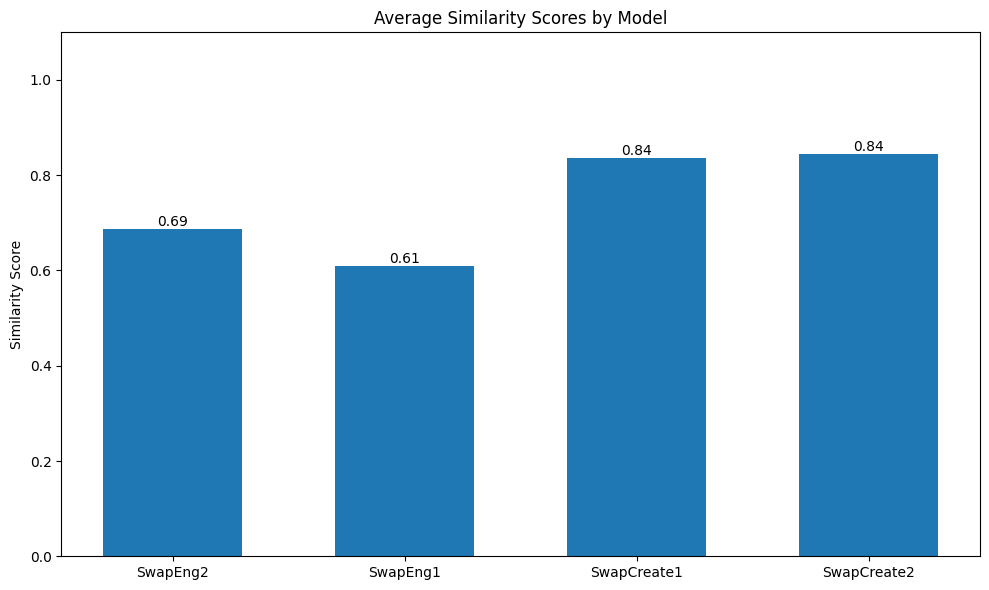

In [ ]:
plt = plot_simple_similarities(avg_sims)
plt.savefig('similarity_scores_n.png', dpi=300)
plt.show()

In [ ]:
iterations = 50
avg_sims_table = sims_table(iterations)
print(f"Average similarities over {iterations} iterations:")
print(avg_sims_table)

Average similarities over 50 iterations:
{'SwapEng2': {'table_inst_vs_select': 0.6176562875807285, 'table_ctx_vs_select': 0.961646673977375}, 'SwapEng1': {'table_inst_vs_select': 0.6030427317519982, 'table_ctx_vs_select': 0.9444630844394366}, 'SwapCreate1': {'table_inst_vs_select': 0.6792783843775589, 'table_ctx_vs_select': 0.9016348114609718}, 'SwapCreate2': {'table_inst_vs_select': 0.6886975199878215, 'table_ctx_vs_select': 0.8888588929772376}}


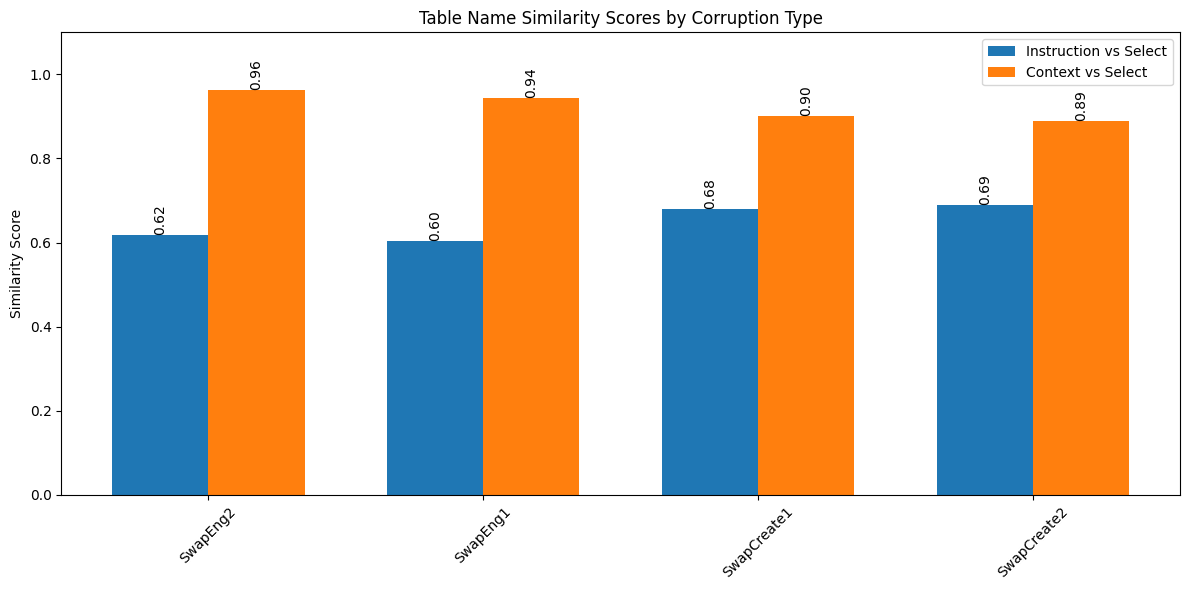

In [ ]:
plt = plot_table_similarities(avg_sims_table)
plt.savefig('table_similarity_scores.png', dpi=300)
plt.show()

In [ ]:
iterations = 50

model_names = ['SwapEng2', 'SwapEng1', 'SwapCreate1', 'SwapCreate2']  # Can be any names
model_functions = {
    'SwapEng2': swap_field_table_eng_2field,
    'SwapEng1': swap_field_table_eng_1field,
    'SwapCreate1': swap_field_table_create_1field,
    'SwapCreate2': swap_field_table_create_2field
}

avg_sim_field = sims_fields(iterations, model_names, model_functions)
print(f"\nAverage similarities over {iterations} iterations:")
print(avg_sim_field)

Processing:   4%|▍         | 2/50 [00:00<00:11,  4.33it/s]

Error in function SwapEng1: 'NoneType' object is not iterable


Processing:   6%|▌         | 3/50 [00:00<00:10,  4.35it/s]

Error in function SwapEng1: 'NoneType' object is not iterable


Processing:  16%|█▌        | 8/50 [00:01<00:08,  4.86it/s]

Error in function SwapEng1: 'NoneType' object is not iterable


Processing:  20%|██        | 10/50 [00:02<00:09,  4.20it/s]

Error in function SwapEng1: 'NoneType' object is not iterable


Processing:  26%|██▌       | 13/50 [00:03<00:10,  3.48it/s]

Error in function SwapEng1: 'NoneType' object is not iterable


Processing:  34%|███▍      | 17/50 [00:04<00:11,  2.98it/s]

Error in function SwapEng1: 'NoneType' object is not iterable


Processing:  42%|████▏     | 21/50 [00:05<00:07,  3.66it/s]

Error in function SwapEng1: 'NoneType' object is not iterable


Processing:  48%|████▊     | 24/50 [00:06<00:06,  3.88it/s]

Error in function SwapEng1: 'NoneType' object is not iterable


Processing:  52%|█████▏    | 26/50 [00:06<00:06,  3.99it/s]

Error in function SwapEng1: 'NoneType' object is not iterable


Processing:  54%|█████▍    | 27/50 [00:07<00:05,  4.14it/s]

Error in function SwapEng1: 'NoneType' object is not iterable


Processing:  58%|█████▊    | 29/50 [00:07<00:04,  4.33it/s]

Error in function SwapEng1: 'NoneType' object is not iterable


Processing:  60%|██████    | 30/50 [00:07<00:04,  4.16it/s]

Error in function SwapEng1: 'NoneType' object is not iterable


Processing:  62%|██████▏   | 31/50 [00:07<00:04,  4.11it/s]

Error in function SwapEng1: 'NoneType' object is not iterable


Processing:  70%|███████   | 35/50 [00:08<00:03,  4.21it/s]

Error in function SwapEng1: 'NoneType' object is not iterable


Processing:  84%|████████▍ | 42/50 [00:10<00:01,  4.26it/s]

Error in function SwapEng1: 'NoneType' object is not iterable


Processing:  88%|████████▊ | 44/50 [00:11<00:01,  4.05it/s]

Error in function SwapEng1: 'NoneType' object is not iterable



Success Statistics:

SwapEng2:
  Field1_resp_int: 50/50 (100.00%)
  Field1_resp_ctx: 50/50 (100.00%)
  Field2_resp_int: 50/50 (100.00%)
  Field2_resp_ctx: 50/50 (100.00%)

SwapEng1:
  Field1_resp_int: 34/50 (68.00%)
  Field1_resp_ctx: 34/50 (68.00%)
  Field2_resp_int: 34/50 (68.00%)
  Field2_resp_ctx: 34/50 (68.00%)

SwapCreate1:
  Field1_resp_int: 50/50 (100.00%)
  Field1_resp_ctx: 50/50 (100.00%)
  Field2_resp_int: 50/50 (100.00%)
  Field2_resp_ctx: 50/50 (100.00%)

SwapCreate2:
  Field1_resp_int: 50/50 (100.00%)
  Field1_resp_ctx: 50/50 (100.00%)
  Field2_resp_int: 50/50 (100.00%)
  Field2_resp_ctx: 50/50 (100.00%)

Average similarities over 50 iterations:
{'SwapEng2': {'Field1_resp_int': 1.0, 'Field1_resp_ctx': 1.0, 'Field2_resp_int': 0.7687103591230181, 'Field2_resp_ctx': 0.5721617047389348}, 'SwapEng1': {'Field1_resp_int': 0.8908488323875501, 'Field1_resp_ctx': 0.5872249725402571, 'Field2_resp_int': 1.0, 'Field2_resp_ctx': 1.0}, 'SwapCreate1': {'Field1_resp_int': 1.0, 'Field1_re

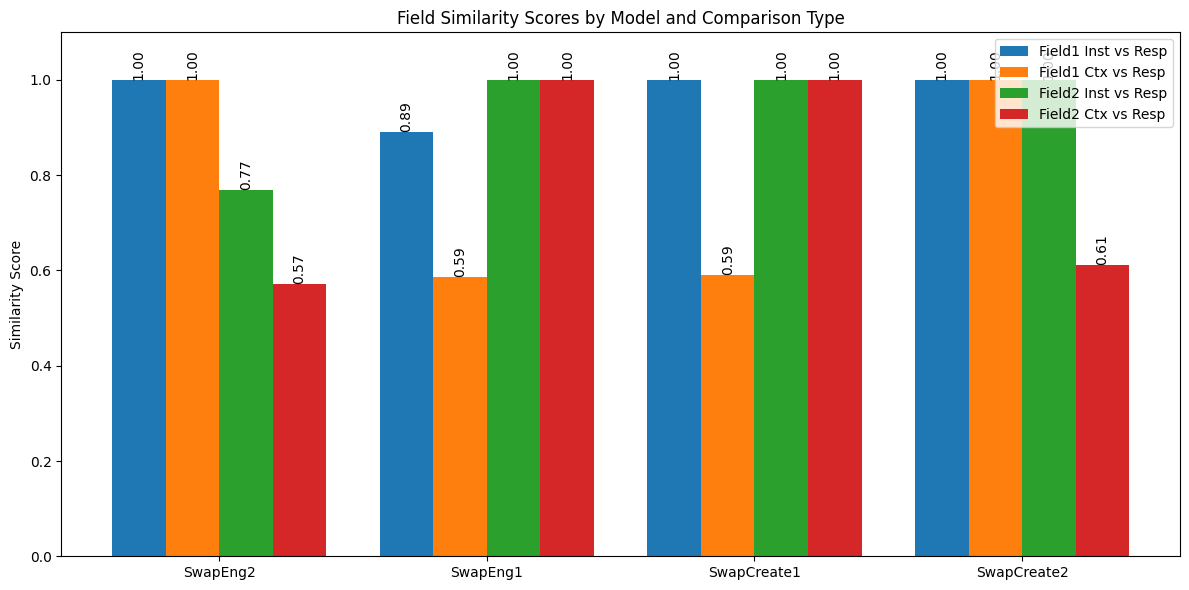

In [ ]:
plt = plot_field_similarities(avg_sim_field)
plt.savefig('field_similarity_scores.png', dpi=300)
plt.show()

### Insignificant tokens -> Random words

In [ ]:
base_item = cpt(1)._make_base_item()
base_prompt = base_item.get_alpaca_prompt()
result = replace_sql_words(base_prompt)
print('Base output: ', generate_output(base_prompt, model_sql, tokenizer_sql), '\n')
print('Random replacement output: ', generate_output(result, model_sql, tokenizer_sql))

Base output:  ### Instruction: show me the name and total from the cost table ### Context: CREATE TABLE cost ( name TEXT, total INT ) ### Response: SELECT name, total FROM cost 

Random replacement output:  ### Instruction: show me hit name under total sky hit cost one ### Context: CREATE TABLE cost ( name TEXT, total INT ) ### Response: SELECT name FROM cost


### Corrupt DefTableName, DefFieldName

In [ ]:
iterations = 50

random_names = ['RandomEng2', 'RandomEng1', 'RandomCreate1', 'RandomCreate2']
random_functions = {
    'RandomEng2': swap_field_table_eng_2field,
    'RandomEng1': swap_field_table_eng_1field,
    'RandomCreate1': swap_field_table_create_1field,
    'RandomCreate2': swap_field_table_create_2field
}

avg_sim_field_rd = sims_fields(iterations, random_names, random_functions)

Processing:   6%|▌         | 3/50 [00:01<00:18,  2.57it/s]

Error in function RandomEng1: 'NoneType' object is not iterable


Processing:  16%|█▌        | 8/50 [00:02<00:12,  3.43it/s]

Error in function RandomEng1: 'NoneType' object is not iterable


Processing:  34%|███▍      | 17/50 [00:04<00:07,  4.61it/s]

Error in function RandomEng1: 'NoneType' object is not iterable


Processing:  52%|█████▏    | 26/50 [00:06<00:05,  4.40it/s]

Error in function RandomEng1: 'NoneType' object is not iterable


Processing:  84%|████████▍ | 42/50 [00:11<00:01,  4.15it/s]

Error in function RandomEng1: 'NoneType' object is not iterable


Processing:  92%|█████████▏| 46/50 [00:12<00:00,  4.39it/s]

Error in function RandomEng1: 'NoneType' object is not iterable


Processing:  94%|█████████▍| 47/50 [00:12<00:00,  4.32it/s]

Error in function RandomEng1: 'NoneType' object is not iterable


Processing:  98%|█████████▊| 49/50 [00:12<00:00,  4.39it/s]

Error in function RandomEng1: 'NoneType' object is not iterable



Success Statistics:

RandomEng2:
  Field1_resp_int: 50/50 (100.00%)
  Field1_resp_ctx: 50/50 (100.00%)
  Field2_resp_int: 50/50 (100.00%)
  Field2_resp_ctx: 50/50 (100.00%)

RandomEng1:
  Field1_resp_int: 42/50 (84.00%)
  Field1_resp_ctx: 42/50 (84.00%)
  Field2_resp_int: 42/50 (84.00%)
  Field2_resp_ctx: 42/50 (84.00%)

RandomCreate1:
  Field1_resp_int: 50/50 (100.00%)
  Field1_resp_ctx: 50/50 (100.00%)
  Field2_resp_int: 50/50 (100.00%)
  Field2_resp_ctx: 50/50 (100.00%)

RandomCreate2:
  Field1_resp_int: 50/50 (100.00%)
  Field1_resp_ctx: 50/50 (100.00%)
  Field2_resp_int: 50/50 (100.00%)
  Field2_resp_ctx: 50/50 (100.00%)


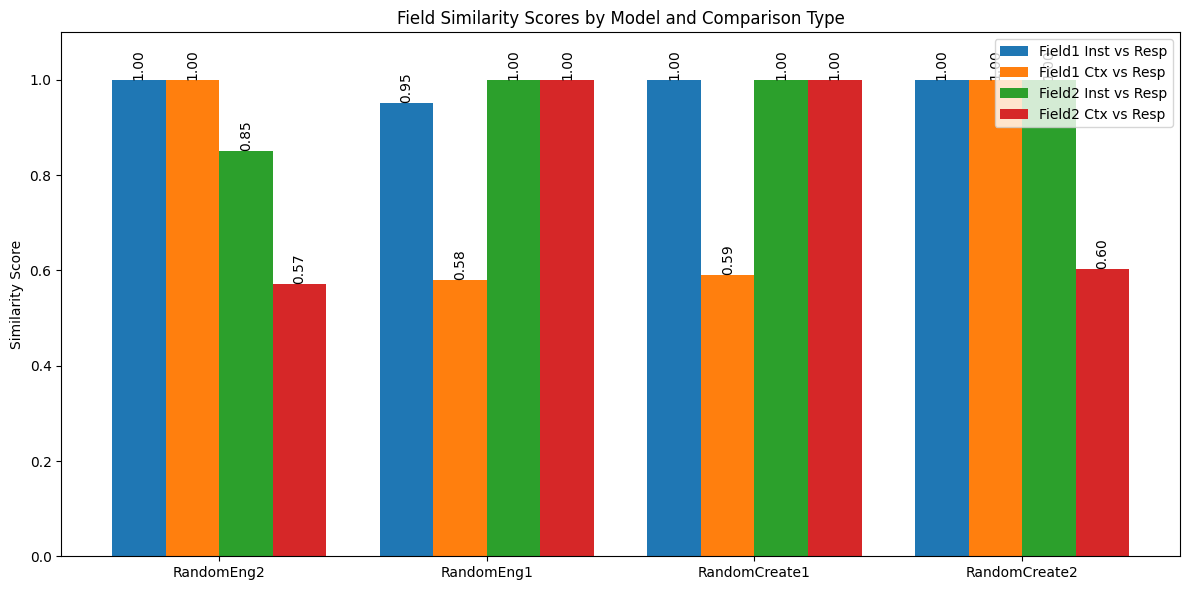

In [ ]:
plt = plot_field_similarities(avg_sim_field_rd)
plt.savefig('field_similarity_scores_random.png', dpi=300)
plt.show()

In [ ]:
base_item = cpt(1)._make_base_item()
#base_prompt = base_item.get_alpaca_prompt()

result1 = replace_field1_instruction(base_prompt)
result2 = replace_field2_instruction(base_prompt)
result3 = replace_field1_context(base_prompt)
result4 = replace_field2_context(base_prompt)


In [ ]:
base_prompt

'### Instruction: show me the id and amount from the inventory table ### Context: CREATE TABLE inventory ( id INT, amount TEXT ) ### Response: '

In [ ]:
generate_output(result1, model_sql, tokenizer_sql)

'### Instruction: show me the rocket and amount from the inventory table ### Context: CREATE TABLE inventory ( id INT, amount TEXT ) ### Response: SELECT amount FROM inventory'

In [ ]:
generate_output(result2, model_sql, tokenizer_sql)

'### Instruction: show me the id and pepper from the inventory table ### Context: CREATE TABLE inventory ( id INT, amount TEXT ) ### Response: SELECT id, salt FROM inventory'

In [ ]:
generate_output(result3, model_sql, tokenizer_sql)

'### Instruction: show me the id and amount from the inventory table ### Context: CREATE TABLE inventory ( ticket INT, amount TEXT ) ### Response: SELECT id, amount FROM inventory'

In [ ]:
generate_output(result4, model_sql, tokenizer_sql)

'### Instruction: show me the id and amount from the inventory table ### Context: CREATE TABLE inventory ( id INT, marble TEXT ) ### Response: SELECT id, amount FROM inventory'

In [ ]:
generate_output(base_prompt.replace('amount from', 'name from'), model_sql, tokenizer_sql)

'### Instruction: show me the id and name from the inventory table ### Context: CREATE TABLE inventory ( id INT, amount TEXT ) ### Response: SELECT id, name FROM inventory'

In [ ]:
generate_output(base_prompt.replace('id CHAR', 'name CHAR'), model_sql, tokenizer_sql)

'### Instruction: show me the color and id from the liquids table ### Context: CREATE TABLE liquids ( color CHAR, name CHAR ) ### Response: SELECT color, id FROM liquids'

In [ ]:
result_table = base_prompt.replace('TABLE inventory', 'TABLE customers')
generate_output(result_table, model_sql, tokenizer_sql)

'### Instruction: show me the id and amount from the inventory table ### Context: CREATE TABLE customers ( id INT, amount TEXT ) ### Response: SELECT id, amount FROM customers'

In [ ]:
base_prompt

'### Instruction: show me the amount and count from the orders table ### Context: CREATE TABLE orders ( amount INT, count TIME ) ### Response: '

In [ ]:
result_table = base_prompt.replace('inventory table', 'customers table')
generate_output(result_table, model_sql, tokenizer_sql)

'### Instruction: show me the id and amount from the customers table ### Context: CREATE TABLE inventory ( id INT, amount TEXT ) ### Response: SELECT id, amount FROM inventory'

In [ ]:
is_in_tiny_stories_vocab('texture', tokenizer_sql)

True

# BM1 CS2

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from TinySQL.load_data.load_model import load_tinysql_model

tokenizer_cs2 = AutoTokenizer.from_pretrained('withmartian/sql_interp_bm1_cs2_experiment_2.8')

model_cs2 = AutoModelForCausalLM.from_pretrained(
    'withmartian/sql_interp_bm1_cs2_experiment_2.8',
    pad_token_id=tokenizer_cs2.pad_token_id
)
model_cs2.config.pad_token_id = tokenizer_cs2.pad_token_id
model_cs2.to('cuda')

tokenizer_config.json:   0%|          | 0.00/883 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.56M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/578 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.04k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/315M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/119 [00:00<?, ?B/s]

GPTNeoForCausalLM(
  (transformer): GPTNeoModel(
    (wte): Embedding(50258, 1024)
    (wpe): Embedding(2048, 1024)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0-1): 2 x GPTNeoBlock(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPTNeoAttention(
          (attention): GPTNeoSelfAttention(
            (attn_dropout): Dropout(p=0.0, inplace=False)
            (resid_dropout): Dropout(p=0.0, inplace=False)
            (k_proj): Linear(in_features=1024, out_features=1024, bias=False)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=False)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=False)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPTNeoMLP(
          (c_fc): Linear(in_features=1024, out_features=4096, bias=True)
          (c_proj): L

## Similarity minimal break

corrupting DefCreateTable


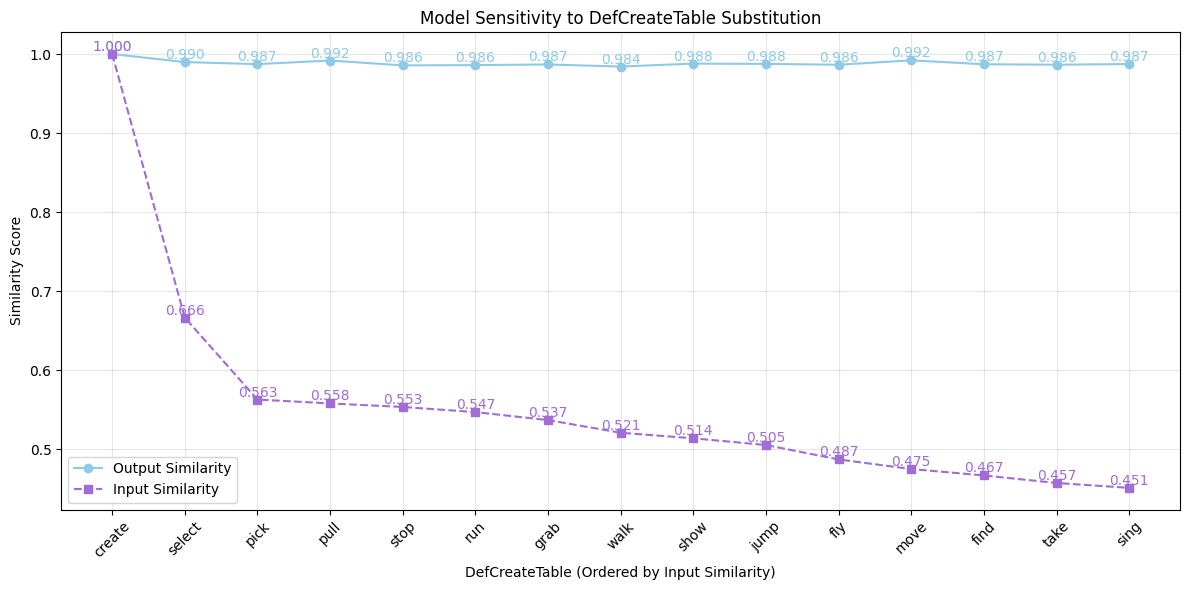

In [ ]:
tester = SimpleSimilarityTester(
    generate_fn=generate_wrapper,
    model=model_cs2,
    tokenizer=tokenizer_cs2,
    corruption="DefCreateTable"
)
results = tester.test_breakdown()

corrupting DefFieldSeparator


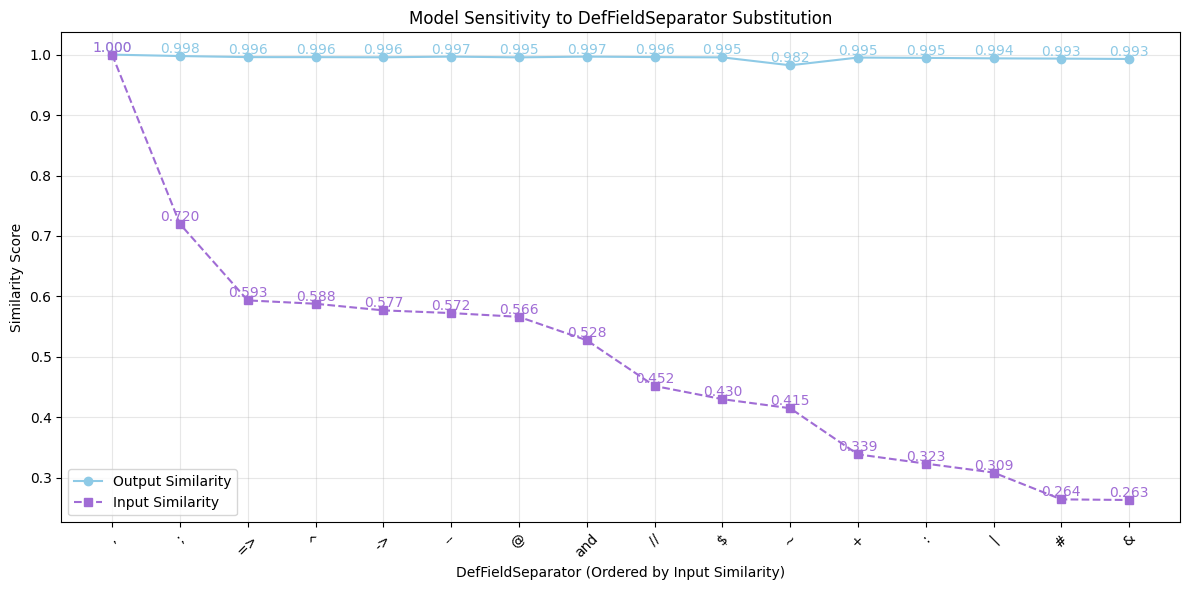

In [ ]:
tester = SimpleSimilarityTester(
    generate_fn=generate_wrapper,
    model=model_cs2,
    tokenizer=tokenizer_cs2,
    corruption="DefFieldSeparator"
)
results = tester.test_breakdown()

## Corrupting fields and tables

In [ ]:
iterations = 10
avg_sims_cs2 = compute_average_similarities(iterations, model_cs2, tokenizer_cs2, use_order_by=True)
print(f"Average similarities over {iterations} iterations:")
print(avg_sims)


100%|██████████| 10/10 [00:08<00:00,  1.18it/s]

Average similarities over 10 iterations:
{'SwapEng2': 0.6879036429380928, 'SwapEng1': 0.6102196657048218, 'SwapCreate1': 0.8356906180865312, 'SwapCreate2': 0.8441529278248996}


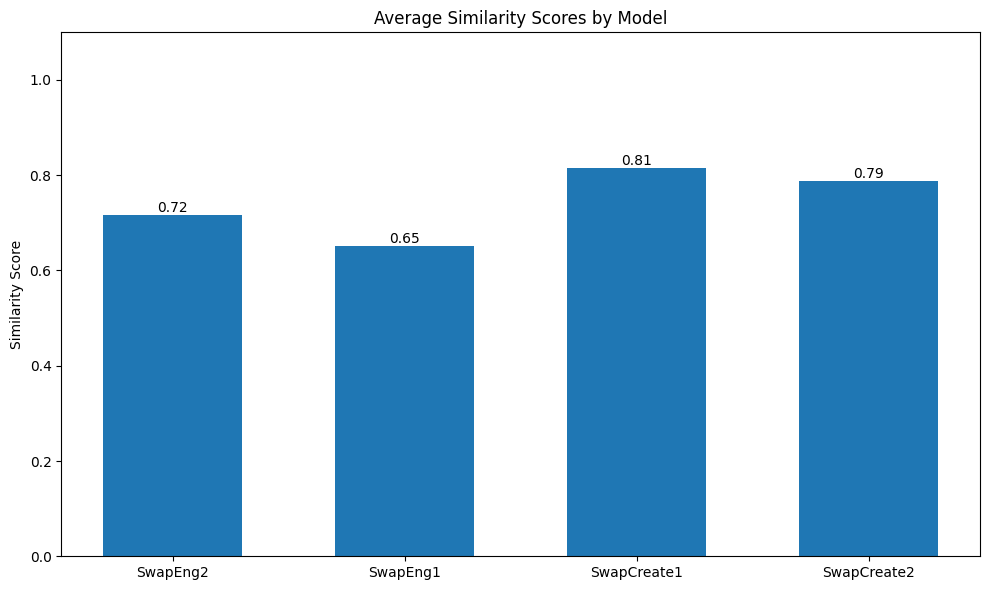

In [ ]:
plt = plot_simple_similarities(avg_sims_cs2)
plt.savefig('similarity_scores_cs2.png', dpi=300)
plt.show()

In [ ]:
iterations = 50
avg_sims_table_cs2 = sims_table(iterations, model_cs2, tokenizer_cs2, use_order_by=True)
print(f"Average similarities over {iterations} iterations:")
print(avg_sims_table_cs2)

Average similarities over 50 iterations:
{'SwapEng2': {'table_inst_vs_select': 0.6391830757757029, 'table_ctx_vs_select': 0.8815249949693679}, 'SwapEng1': {'table_inst_vs_select': 0.6484741209050019, 'table_ctx_vs_select': 0.8684669826428094}, 'SwapCreate1': {'table_inst_vs_select': 0.6410960129598776, 'table_ctx_vs_select': 0.9335104795694352}, 'SwapCreate2': {'table_inst_vs_select': 0.6451495689054331, 'table_ctx_vs_select': 0.9352014598250389}}


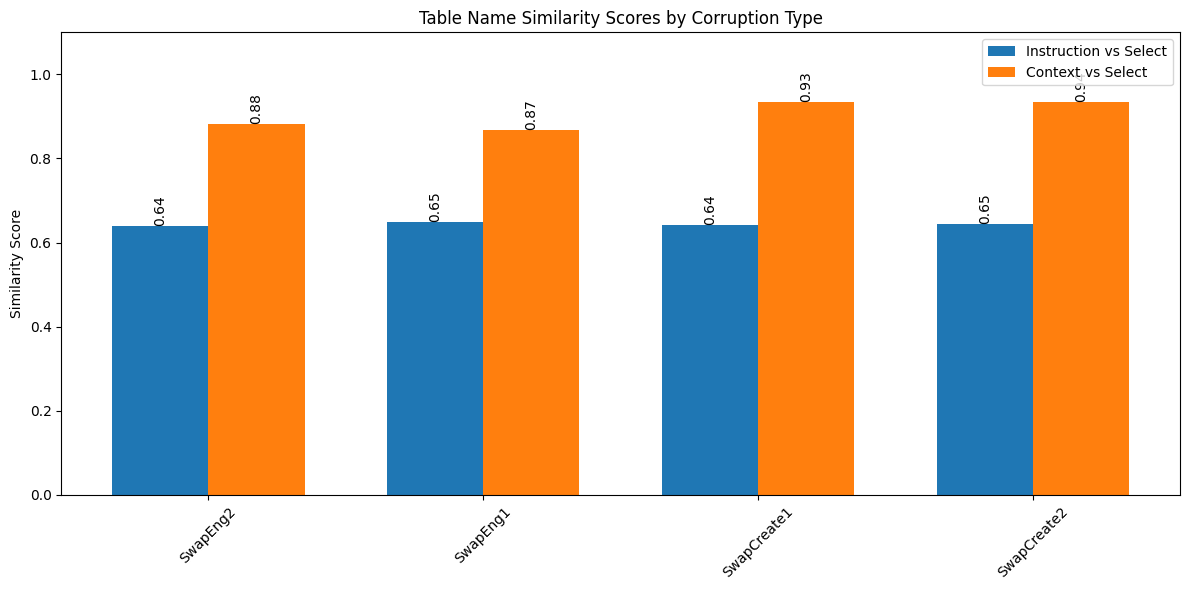

In [ ]:
plt = plot_table_similarities(avg_sims_table_cs2)
plt.savefig('table_similarity_scores_cs2.png', dpi=300)
plt.show()

In [ ]:
iterations = 50

model_names = ['SwapEng2', 'SwapEng1', 'SwapCreate1', 'SwapCreate2']  # Can be any names
model_functions = {
    'SwapEng2': swap_field_table_eng_2field,
    'SwapEng1': swap_field_table_eng_1field,
    'SwapCreate1': swap_field_table_create_1field,
    'SwapCreate2': swap_field_table_create_2field
}

avg_sim_field_cs2 = sims_fields(iterations, model_names, model_functions, model_cs2, tokenizer_cs2, use_order_by=True)
print(f"\nAverage similarities over {iterations} iterations:")
print(avg_sim_field_cs2)

Processing:  10%|█         | 5/50 [00:01<00:13,  3.26it/s]

Error in function SwapEng1: 'NoneType' object is not iterable


Processing:  16%|█▌        | 8/50 [00:02<00:15,  2.65it/s]

Error in function SwapEng1: 'NoneType' object is not iterable


Processing:  18%|█▊        | 9/50 [00:03<00:15,  2.72it/s]

Error in function SwapEng1: 'NoneType' object is not iterable


Processing:  40%|████      | 20/50 [00:07<00:10,  3.00it/s]

Error in function SwapEng1: 'NoneType' object is not iterable


Processing:  50%|█████     | 25/50 [00:08<00:07,  3.18it/s]

Error in function SwapEng1: 'NoneType' object is not iterable


Processing:  56%|█████▌    | 28/50 [00:09<00:06,  3.21it/s]

Error in function SwapEng1: 'NoneType' object is not iterable


Processing:  64%|██████▍   | 32/50 [00:10<00:05,  3.23it/s]

Error in function SwapEng1: 'NoneType' object is not iterable


Processing:  88%|████████▊ | 44/50 [00:14<00:01,  3.21it/s]

Error in function SwapEng1: 'NoneType' object is not iterable


Processing:  98%|█████████▊| 49/50 [00:16<00:00,  2.61it/s]

Error in function SwapEng1: 'NoneType' object is not iterable



Success Statistics:

SwapEng2:
  Field1_resp_int: 50/50 (100.00%)
  Field1_resp_ctx: 50/50 (100.00%)
  Field2_resp_int: 50/50 (100.00%)
  Field2_resp_ctx: 50/50 (100.00%)

SwapEng1:
  Field1_resp_int: 41/50 (82.00%)
  Field1_resp_ctx: 41/50 (82.00%)
  Field2_resp_int: 41/50 (82.00%)
  Field2_resp_ctx: 41/50 (82.00%)

SwapCreate1:
  Field1_resp_int: 50/50 (100.00%)
  Field1_resp_ctx: 50/50 (100.00%)
  Field2_resp_int: 50/50 (100.00%)
  Field2_resp_ctx: 50/50 (100.00%)

SwapCreate2:
  Field1_resp_int: 50/50 (100.00%)
  Field1_resp_ctx: 50/50 (100.00%)
  Field2_resp_int: 50/50 (100.00%)
  Field2_resp_ctx: 50/50 (100.00%)

Average similarities over 50 iterations:
{'SwapEng2': {'Field1_resp_int': 1.0, 'Field1_resp_ctx': 1.0, 'Field2_resp_int': 0.8107667950921589, 'Field2_resp_ctx': 0.669444690654675}, 'SwapEng1': {'Field1_resp_int': 0.8743803440555324, 'Field1_resp_ctx': 0.5569058519311066, 'Field2_resp_int': 1.0, 'Field2_resp_ctx': 1.0}, 'SwapCreate1': {'Field1_resp_int': 1.0, 'Field1_res

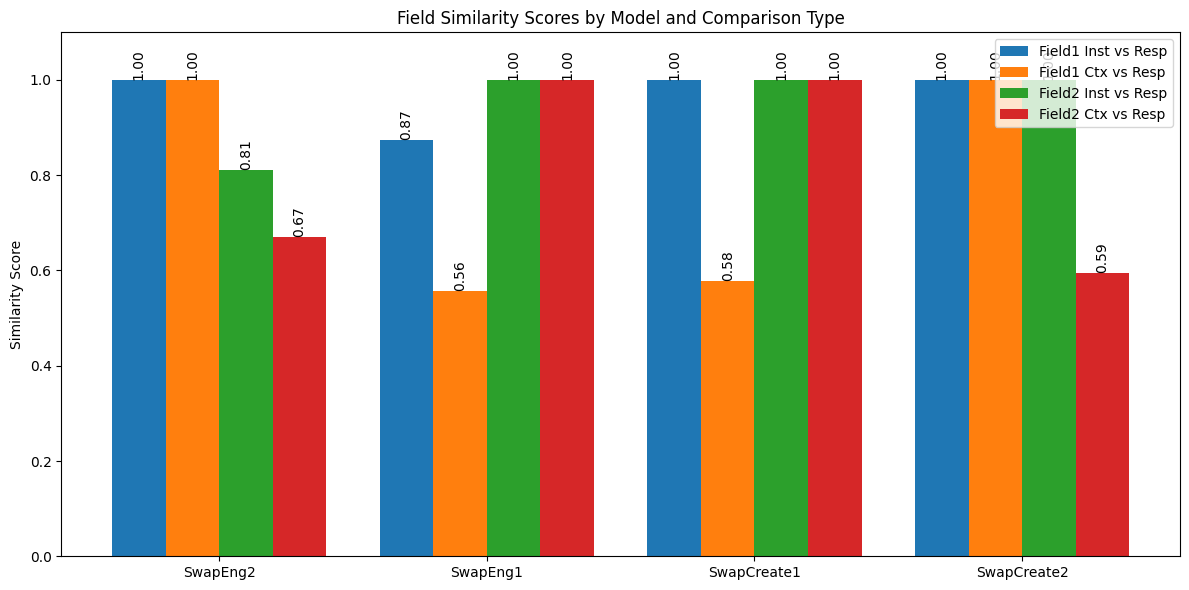

In [ ]:
plt = plot_field_similarities(avg_sim_field_cs2)
plt.savefig('field_similarity_scores_cs2.png', dpi=300)
plt.show()

In [ ]:
base_item = CorruptFeatureTestGenerator(use_order_by=True)._make_base_item()
base_prompt = base_item.get_alpaca_prompt()
result = replace_sql_words(base_prompt)
print('Base output: ', generate_output(base_prompt, model_cs2, tokenizer_cs2), '\n')
print('Random replacement output: ', generate_output(result, model_cs2, tokenizer_cs2))

Base output:  ### Instruction: show me the id and price from the people table ordered by id in ascending order ### Context: CREATE TABLE people ( id JSON, price TIME ) ### Response: SELECT id, price FROM people ORDER BY id ASC 

Random replacement output:  ### Instruction: show me hit id under price sky hit people one ordered by id in ascending order ### Context: CREATE TABLE people ( id JSON, price TIME ) ### Response: SELECT push_token, id FROM customers ORDER BY id ASC


In [ ]:
iterations = 50

random_names = ['RandomEng2', 'RandomEng1', 'RandomCreate1', 'RandomCreate2']
random_functions = {
    'RandomEng2': swap_field_table_eng_2field,
    'RandomEng1': swap_field_table_eng_1field,
    'RandomCreate1': swap_field_table_create_1field,
    'RandomCreate2': swap_field_table_create_2field
}

avg_sim_field_rd_cs2 = sims_fields(iterations, random_names, random_functions, model_cs2, tokenizer_cs2)

Processing:   6%|▌         | 3/50 [00:00<00:14,  3.17it/s]

Error in function RandomEng1: 'NoneType' object is not iterable


Processing:  26%|██▌       | 13/50 [00:04<00:13,  2.73it/s]

Error in function RandomEng1: 'NoneType' object is not iterable


Processing:  34%|███▍      | 17/50 [00:06<00:13,  2.51it/s]

Error in function RandomEng1: 'NoneType' object is not iterable


Processing:  50%|█████     | 25/50 [00:08<00:08,  2.91it/s]

Error in function RandomEng1: 'NoneType' object is not iterable


Processing:  52%|█████▏    | 26/50 [00:09<00:08,  2.85it/s]

Error in function RandomEng1: 'NoneType' object is not iterable


Processing:  82%|████████▏ | 41/50 [00:13<00:02,  3.42it/s]

Error in function RandomEng1: 'NoneType' object is not iterable


Processing:  86%|████████▌ | 43/50 [00:14<00:02,  3.26it/s]

Error in function RandomEng1: 'NoneType' object is not iterable


Processing:  96%|█████████▌| 48/50 [00:15<00:00,  3.11it/s]

Error in function RandomEng1: 'NoneType' object is not iterable



Success Statistics:

RandomEng2:
  Field1_resp_int: 50/50 (100.00%)
  Field1_resp_ctx: 50/50 (100.00%)
  Field2_resp_int: 50/50 (100.00%)
  Field2_resp_ctx: 50/50 (100.00%)

RandomEng1:
  Field1_resp_int: 42/50 (84.00%)
  Field1_resp_ctx: 42/50 (84.00%)
  Field2_resp_int: 42/50 (84.00%)
  Field2_resp_ctx: 42/50 (84.00%)

RandomCreate1:
  Field1_resp_int: 50/50 (100.00%)
  Field1_resp_ctx: 50/50 (100.00%)
  Field2_resp_int: 50/50 (100.00%)
  Field2_resp_ctx: 50/50 (100.00%)

RandomCreate2:
  Field1_resp_int: 50/50 (100.00%)
  Field1_resp_ctx: 50/50 (100.00%)
  Field2_resp_int: 50/50 (100.00%)
  Field2_resp_ctx: 50/50 (100.00%)


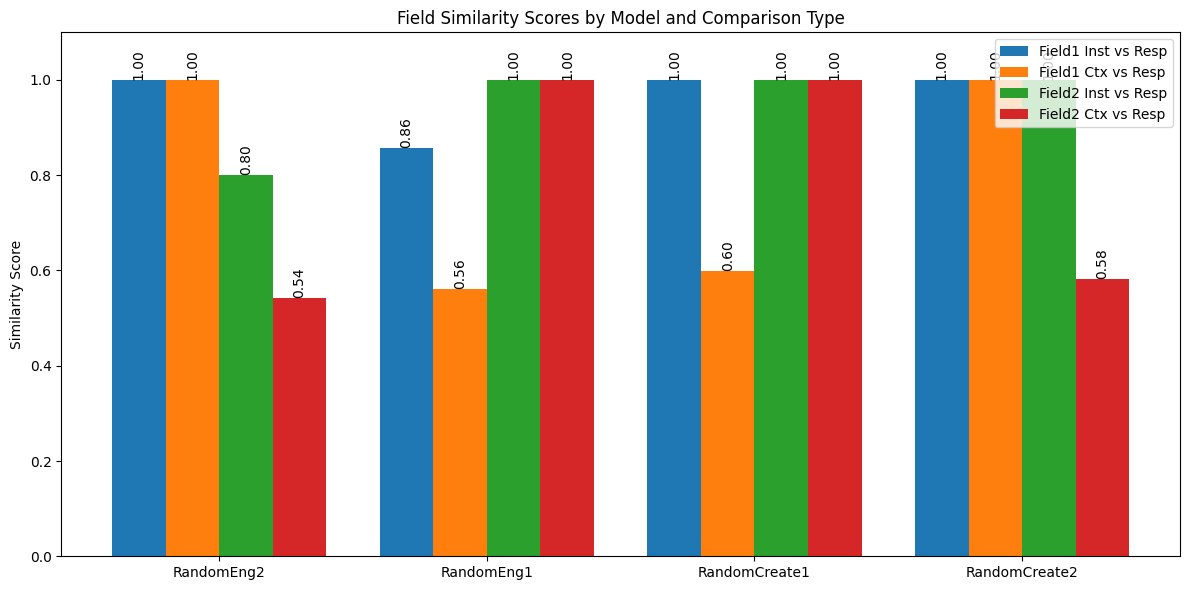

In [ ]:
plt = plot_field_similarities(avg_sim_field_rd_cs2)
plt.savefig('field_similarity_scores_cs2_random.png', dpi=300)
plt.show()

In [ ]:
base_item = CorruptFeatureTestGenerator(use_order_by=True)._make_base_item()
base_prompt = base_item.get_alpaca_prompt()

result1 = replace_field1_instruction(base_prompt)
result2 = replace_field2_instruction(base_prompt)
result3 = replace_field1_context(base_prompt)
result4 = replace_field2_context(base_prompt)


In [ ]:
generate_output(result1, model_cs2, tokenizer_cs2)

'### Instruction: show me the cookie and amount from the orders table ordered by amount in ascending order ### Context: CREATE TABLE orders ( name JSON, amount TEXT ) ### Response: SELECT cookies, amount FROM orders ORDER BY amount ASC'

In [ ]:
generate_output(result2, model_cs2, tokenizer_cs2)

'### Instruction: show me the name and cookie from the orders table ordered by amount in ascending order ### Context: CREATE TABLE orders ( name JSON, amount TEXT ) ### Response: SELECT name, cookies FROM orders ORDER BY amount ASC'

In [ ]:
generate_output(result3, model_cs2, tokenizer_cs2)

'### Instruction: show me the name and amount from the orders table ordered by amount in ascending order ### Context: CREATE TABLE orders ( castle JSON, amount TEXT ) ### Response: SELECT name, amount FROM orders ORDER BY amount ASC'

In [ ]:
generate_output(result4, model_cs2, tokenizer_cs2)

'### Instruction: show me the name and amount from the orders table ordered by amount in ascending order ### Context: CREATE TABLE orders ( name JSON, flower TEXT ) ### Response: SELECT name, amount FROM orders ORDER BY amount ASC'

In [ ]:
generate_output(base_prompt.replace('amount from', 'id from'), model_cs2, tokenizer_cs2)

'### Instruction: show me the name and id from the orders table ordered by amount in ascending order ### Context: CREATE TABLE orders ( name JSON, amount TEXT ) ### Response: SELECT name, id FROM orders ORDER BY amount ASC'

In [ ]:
generate_output(base_prompt.replace('price CHAR', 'id CHAR'), model_cs2, tokenizer_cs2)

'### Instruction: show me the name and amount from the orders table ordered by amount in ascending order ### Context: CREATE TABLE orders ( name JSON, amount TEXT ) ### Response: SELECT name, amount FROM orders ORDER BY amount ASC'

In [ ]:
generate_output(base_prompt.replace('orders table', 'personal table'), model_cs2, tokenizer_cs2)

'### Instruction: show me the name and amount from the personal table ordered by amount in ascending order ### Context: CREATE TABLE orders ( name JSON, amount TEXT ) ### Response: SELECT name, amount FROM orders ORDER BY amount ASC'

In [ ]:
generate_output(base_prompt.replace('TABLE orders', 'TABLE personal'), model_cs2, tokenizer_cs2)

'### Instruction: show me the name and amount from the orders table ordered by amount in ascending order ### Context: CREATE TABLE personal ( name JSON, amount TEXT ) ### Response: SELECT name, amount FROM personal ORDER BY amount ASC'

# BM2 CS1

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from TinySQL.load_data.load_model import load_tinysql_model

device = torch.device('cuda')

tokenizer_bm2_cs1 = AutoTokenizer.from_pretrained('withmartian/sql_interp_bm2_cs2_experiment_5.2')
tokenizer_bm2_cs1.pad_token = tokenizer_bm2_cs1.eos_token

model_bm2_cs1= AutoModelForCausalLM.from_pretrained(
    'withmartian/sql_interp_bm2_cs2_experiment_5.2',
    pad_token_id=tokenizer_bm2_cs1.eos_token_id
)
model_bm2_cs1.config.pad_token_id = tokenizer_bm2_cs1.pad_token_id
model_bm2_cs1.to(device)

tokenizer_config.json:   0%|          | 0.00/7.50k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/605 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/613 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/757 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(151936, 896, padding_idx=151645)
    (layers): ModuleList(
      (0-23): 24 x Qwen2DecoderLayer(
        (self_attn): Qwen2SdpaAttention(
          (q_proj): Linear(in_features=896, out_features=896, bias=True)
          (k_proj): Linear(in_features=896, out_features=128, bias=True)
          (v_proj): Linear(in_features=896, out_features=128, bias=True)
          (o_proj): Linear(in_features=896, out_features=896, bias=False)
          (rotary_emb): Qwen2RotaryEmbedding()
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear(in_features=896, out_features=4864, bias=False)
          (up_proj): Linear(in_features=896, out_features=4864, bias=False)
          (down_proj): Linear(in_features=4864, out_features=896, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
      )
    )
    (n

In [ ]:
base_prompt

'### Instruction: show me the price and amount from the cost table ordered by price in ascending order ### Context: CREATE TABLE cost ( price CHAR, amount CHAR ) ### Response: '

In [ ]:
base_item = cpt(use_order_by=True)._make_base_item()
base_prompt = base_item.get_alpaca_prompt()
base_output = generate_output(base_prompt, model_bm2_cs1, tokenizer_bm2_cs1)
base_output

'### Instruction: show me the price and amount from the cost table ordered by price in ascending order ### Context: CREATE TABLE cost ( price CHAR, amount CHAR ) ### Response: SELECT price, amount FROM cost ORDER BY price ASC'

In [ ]:
generate_output(base_prompt.replace('TABLE inventory', 'TABLE personal'), model_bm2_cs1, tokenizer_bm2_cs1)

'### Instruction: show me the amount and name from the inventory table ordered by name in ascending order ### Context: CREATE TABLE personal ( amount TIME, name INT ) ### Response: SELECT amount, name FROM inventory ORDER BY name ASC'

In [ ]:
generate_output(base_prompt.replace('inventory table', 'personal table'), model_bm2_cs1, tokenizer_bm2_cs1)

'### Instruction: show me the amount and name from the personal table ordered by name in ascending order ### Context: CREATE TABLE inventory ( amount TIME, name INT ) ### Response: SELECT amount, name FROM personal ORDER BY name ASC'

In [ ]:
generate_output(base_prompt.replace('name INT', 'id tkh'), model_bm2_cs1, tokenizer_bm2_cs1)

'### Instruction: show me the amount and name from the inventory table ordered by name in ascending order ### Context: CREATE TABLE inventory ( amount TIME, id tkh ) ### Response: SELECT amount, name FROM inventory ORDER BY name ASC'

In [ ]:
generate_output(base_prompt.replace('CREATE TABLE inventory ( amount TIME, name INT )', ' Bla bla bla bla bla bal bla bla'), model_bm2_cs1, tokenizer_bm2_cs1)

'### Instruction: show me the amount and name from the inventory table ordered by name in ascending order ### Context:  Bla bla bla bla bla bal bla bla ### Response: SELECT amount, name FROM inventory ORDER BY name ASC'

In [ ]:
base_item = cpt()._make_base_item()
base_prompt = base_item.get_alpaca_prompt()
result = replace_sql_words(base_prompt)
print('Base output: ', generate_output(base_prompt, model_bm2_cs1, tokenizer_bm2_cs1), '\n')
print('Random replacement output: ', generate_output(result, model_bm2_cs1, tokenizer_bm2_cs1))

Base output:  ### Instruction: show me the price and name from the orders table ### Context: CREATE TABLE orders ( price TIME, name JSON ) ### Response: SELECT price, name FROM orders  

Random replacement output:  ### Instruction: show me hit price under name sky hit orders one ### Context: CREATE TABLE orders ( price TIME, name JSON ) ### Response: SELECT hit_price FROM name WHERE tax_amount IS NULL ORDER BY order_id DESC, is_public DESC,


/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:633: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.8` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:650: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `20` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(


corrupting DefCreateTable


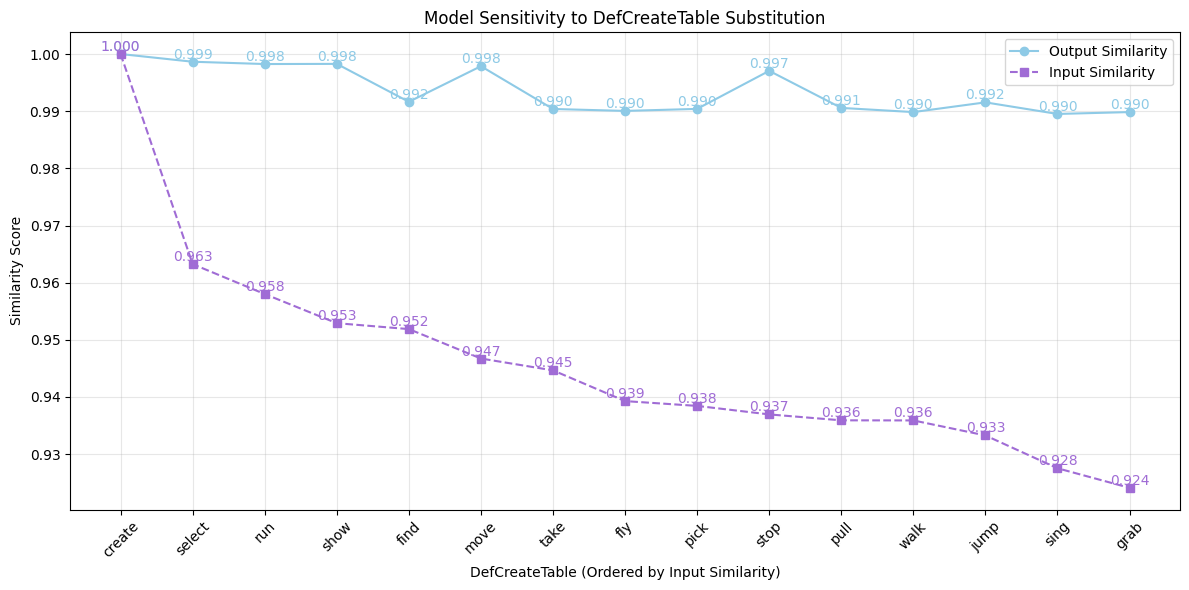

In [ ]:
tester = SimpleSimilarityTester(
    generate_fn=generate_wrapper,
    model=model_bm2_cs1,
    tokenizer=tokenizer_bm2_cs1,
    corruption="DefCreateTable",
    model_type='qwen'
)

results = tester.test_breakdown()

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:633: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.8` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:650: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `20` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(


corrupting DefFieldSeparator


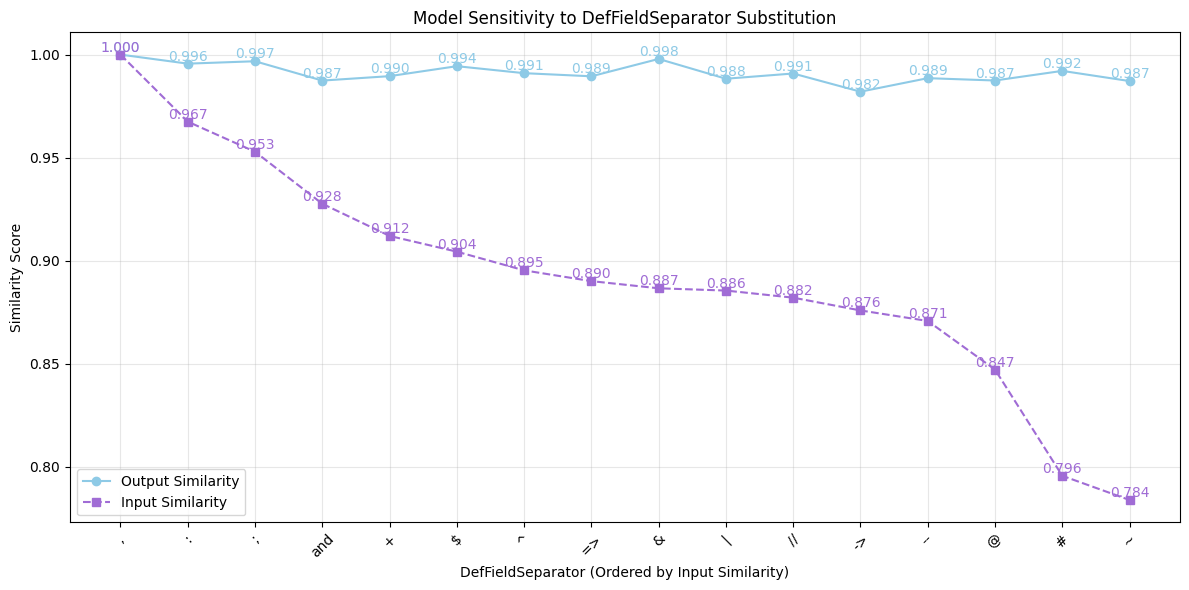

In [ ]:
tester = SimpleSimilarityTester(
    generate_fn=generate_wrapper,
    model=model_bm2_cs1,
    tokenizer=tokenizer_bm2_cs1,
    corruption="DefFieldSeparator",
    model_type='qwen'
)

results = tester.test_breakdown()

#BM3 CS1

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from TinySQL.load_data.load_model import load_tinysql_model

device = torch.device('cuda')

tokenizer_bm3_cs1 = AutoTokenizer.from_pretrained('withmartian/sql_interp_bm3_cs2_experiment_8.2')
tokenizer_bm3_cs1.pad_token = tokenizer_bm3_cs1.eos_token

model_bm3_cs1= AutoModelForCausalLM.from_pretrained(
    'withmartian/sql_interp_bm3_cs2_experiment_8.2'
    # pad_token_id=tokenizer_bm2_cs1.eos_token_id
)
model_bm3_cs1.config.pad_token_id = tokenizer_bm3_cs1.pad_token_id
model_bm3_cs1.to(device)

tokenizer_config.json:   0%|          | 0.00/54.8k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/454 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/972 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/4.94G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/184 [00:00<?, ?B/s]

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 2048, padding_idx=128004)
    (layers): ModuleList(
      (0-15): 16 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=512, bias=False)
          (v_proj): Linear(in_features=2048, out_features=512, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (up_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (down_proj): Linear(in_features=8192, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
     

In [ ]:
base_item = cpt(use_order_by=True)._make_base_item()
base_prompt = base_item.get_alpaca_prompt()
base_output = generate_output(base_prompt, model_bm3_cs1, tokenizer_bm3_cs1)
base_output

In [ ]:
generate_output(base_prompt.replace('cost table', 'things table'), model_bm3_cs1, tokenizer_bm3_cs1)

'### Instruction: show me the price and amount from the things table ordered by price in ascending order ### Context: CREATE TABLE cost ( price CHAR, amount CHAR ) ### Response: SELECT price, amount FROM things ORDER BY price ASC'

In [ ]:
generate_output(base_prompt.replace('Context: CREATE TABLE cost ( price CHAR, amount CHAR )', ' Bla bla bla bla bla bal bla bla'), model_bm3_cs1, tokenizer_bm3_cs1)

'### Instruction: show me the price and amount from the cost table ordered by price in ascending order ###  Bla bla bla bla bla bal bla bla ### Response: SELECT price, amount FROM cost ORDER BY price ASC'

In [ ]:
generate_output(base_prompt.replace('amount from', 'people from'), model_bm3_cs1, tokenizer_bm3_cs1)

'### Instruction: show me the price and people from the cost table ordered by price in ascending order ### Context: CREATE TABLE cost ( price CHAR, amount CHAR ) ### Response: SELECT price, people FROM cost ORDER BY price ASC'